#**California Housing Dataset**#

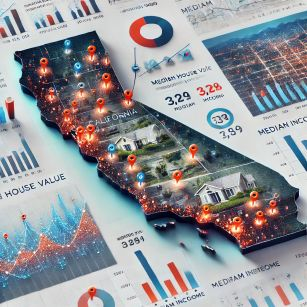

#**Table of Contents**
* Business Problem
* BLUF
* Libraries
* Data
* Engineering
* Regressors
  * Regression Tree
  * Multiple Linear Regression
  * PyTorch Model (neural network)
  * PyCaret Model (low-code model)
* Conclusion

#**Business Problem**#

To provide a valuation for a residential property in California for which the daatset is representative. MSE is the desired metric.

#**Bottom Line Up Front**#

Hierarchical clustering is used to engineer a new latitude-longitude feature. k-Means clustering is used to engineer a new feature that leverages number of rooms and home age.

Multiple Linear Regression (including simple MLR, LASSO, ridge and elasticnet models), regression tree, PyTorch Lightning and PyCaret regressors are developed.

Overall, the PyCaret (LightGBM) model seems best (with an MSE of ~0.2). But the compute for that model is much higher and one of the linear regression models may deliver the best bang for your buck (MSE of ~0.5).

#**Libraries**#

In [ ]:
# Install PyTorch Lightning
!pip install pytorch-lightning

In [ ]:
# Install PyCaret
!pip install pycaret

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#sklearn
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score, learning_curve
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.feature_selection import RFE

# scipy
from scipy.stats import skew

# PyCaret
from pycaret.regression import *

#PyTorch Lightning
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset

# time
import time

#**Data**#

| Column Name         | Data Type   | Description                                                                                   |
|----------------------|-------------|-----------------------------------------------------------------------------------------------|
| **longitude**        | Float       | The longitude coordinate of the property (Western US).                                       |
| **latitude**         | Float       | The latitude coordinate of the property (Western US).                                        |
| **housing_median_age** | Integer  | The median age of the housing units in the area.                                             |
| **total_rooms**      | Integer     | Total number of rooms in all housing units in the area.                                      |
| **total_bedrooms**   | Integer     | Total number of bedrooms in all housing units in the area.                                   |
| **population**       | Integer     | The total population residing in the area.                                                  |
| **households**       | Integer     | Total number of households in the area.                                                     |
| **median_income**    | Float       | The median income of households in the area (scaled to USD in tens of thousands).            |
| **median_house_value** | Float    | The median value of houses in the area (in USD).                                             |
| **ocean_proximity**  | Categorical | The proximity of the location to the ocean, with values like `NEAR BAY`, `INLAND`, etc.      |

### Notes:
- **Target Variable**: `median_house_value` is often used as the target variable in regression tasks.
- **Categorical Variable**: `ocean_proximity` is a nominal variable with discrete categories.
- **Feature Scaling**: Variables like `median_income` may already be scaled.
- **Null Values**: Some datasets may include missing values in the `total_bedrooms` column, which require handling.

This dataset is commonly used in machine learning tasks to predict house prices or analyze geographical and socioeconomic trends.


In [ ]:
# Load the California housing dataset
X, y = fetch_california_housing(return_X_y=True)
X = pd.DataFrame(X, columns=[
    "MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude"
])
y = pd.Series(y, name="MedianHouseValue")

#**Engineering**#

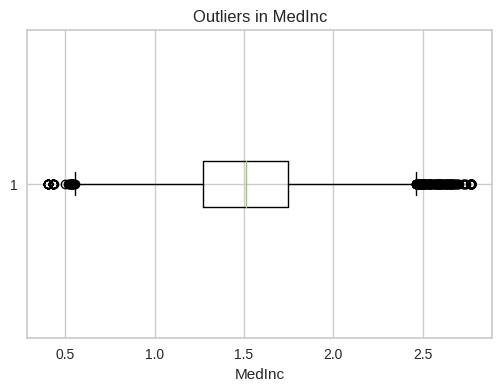

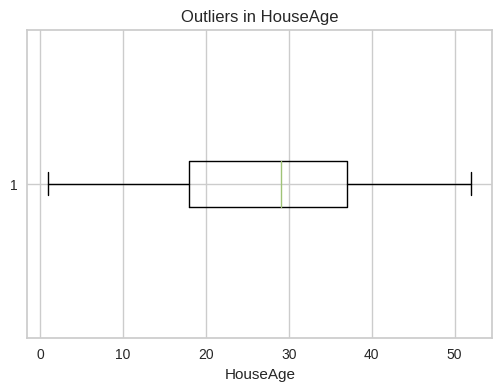

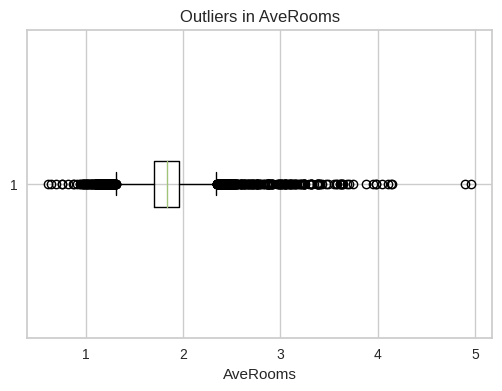

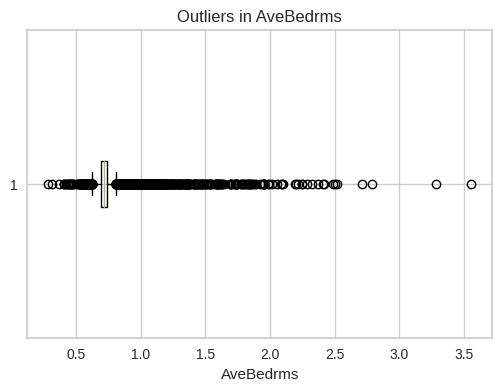

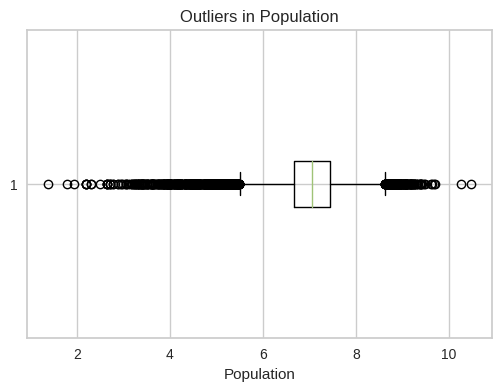

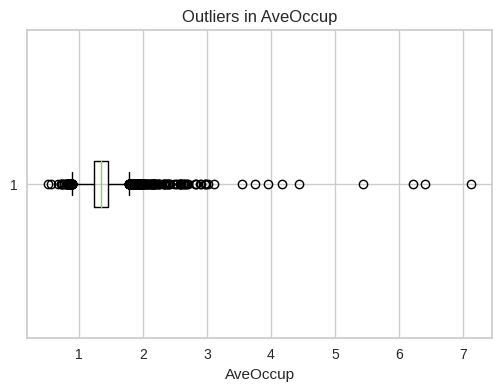

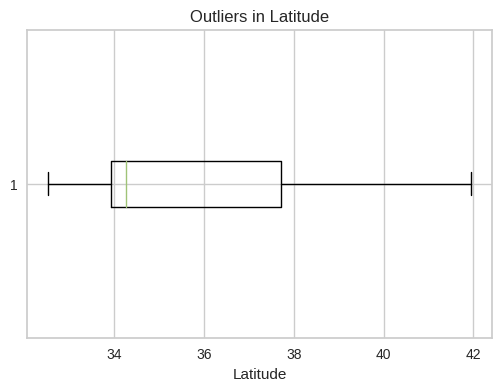

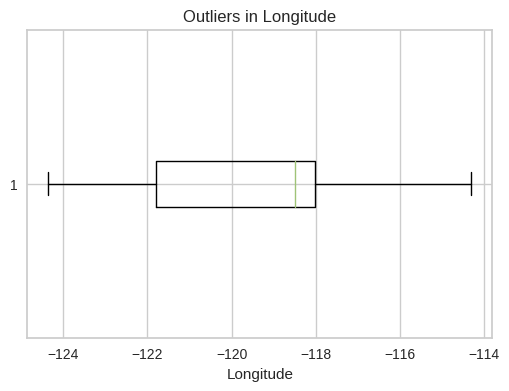

In [ ]:
# Remove duplicates
X = X.drop_duplicates()

# Check for NaNs and impute with median
X = X.fillna(X.median())

# Check skewness and log-transform highly skewed features
skewness = X.apply(lambda x: skew(x))
skewed_features = skewness[skewness > 1].index
X[skewed_features] = np.log1p(X[skewed_features])

# Plot outliers for each feature
for column in X.columns:
    plt.figure(figsize=(6, 4))
    plt.boxplot(X[column], vert=False)
    plt.title(f"Outliers in {column}")
    plt.xlabel(column)
    plt.show()

# Encode categorical features if they exist (example placeholder)
# For this dataset, all features are numerical, so this step is skipped.
# If categorical features existed:
X["CategoricalColumn"] = LabelEncoder().fit_transform(X["CategoricalColumn"])

# Add hierarchical clustering feature based on Latitude and Longitude
hierarchical_cluster = AgglomerativeClustering(n_clusters=5)
X["LocationCluster"] = hierarchical_cluster.fit_predict(X[["Latitude", "Longitude"]])

# Add k-means clustering feature based on Total Rooms and Housing Median Age
kmeans = KMeans(n_clusters=5, random_state=42)
X["RoomAgeCluster"] = kmeans.fit_predict(X[["AveRooms", "HouseAge"]])

feature_names = ["MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude", "LocationCluster", "RoomAgeCluster"]

#**Regressors**#

##**Regression Tree**##


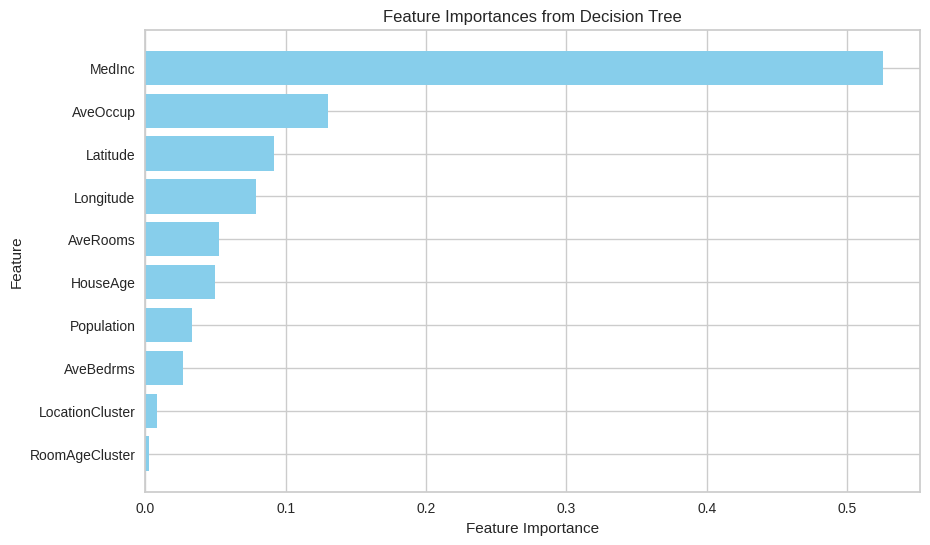

In [ ]:
# Determine feature importance for a regression tree model
regressor = DecisionTreeRegressor(random_state=42)
regressor.fit(X, y)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': regressor.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importances from Decision Tree")
plt.gca().invert_yaxis()
plt.show()

Scaler: standard, Model: DecisionTree, Average MSE: 0.5176


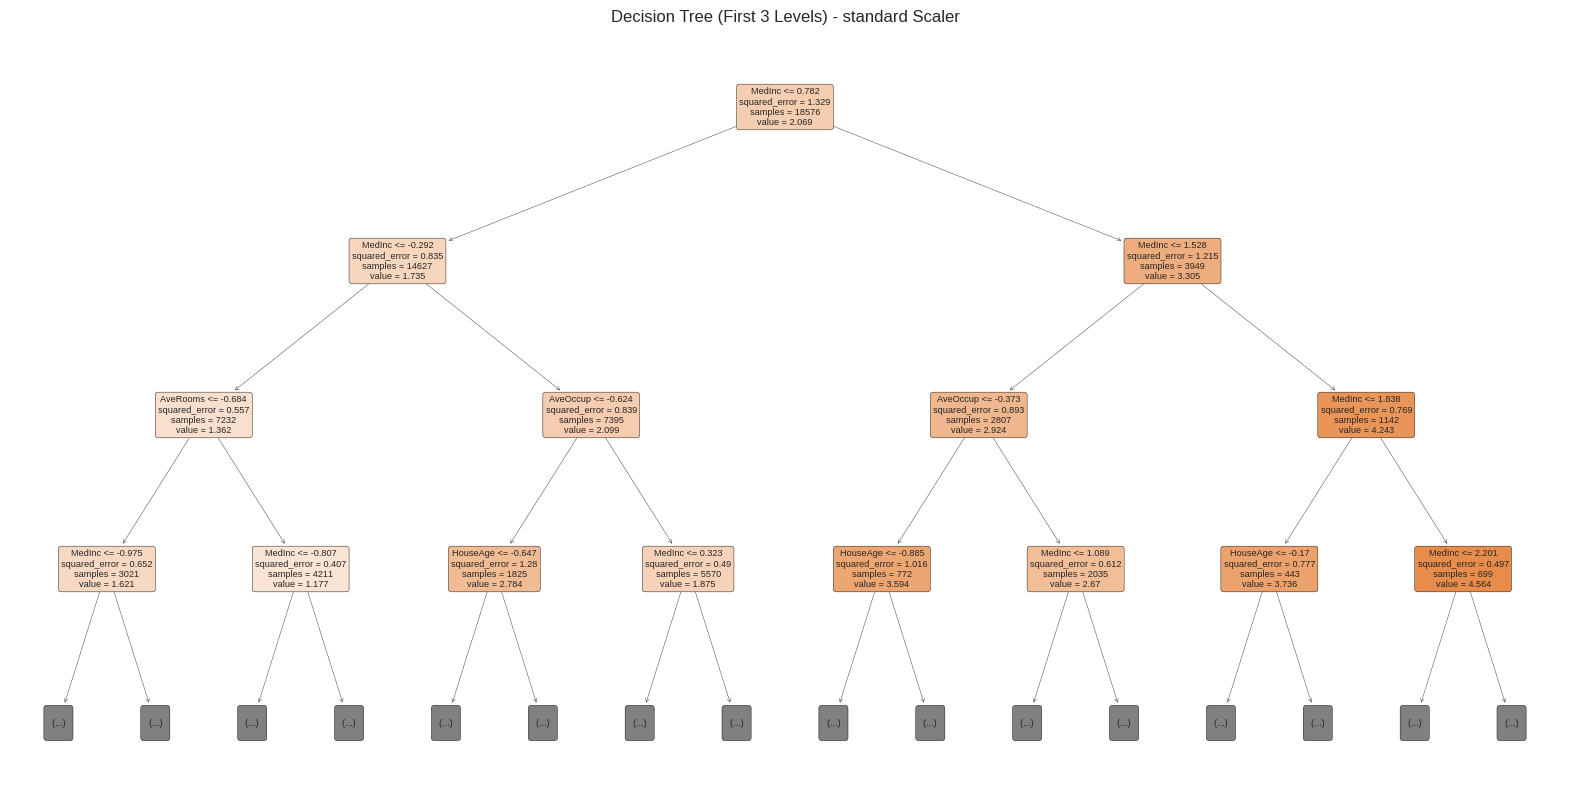

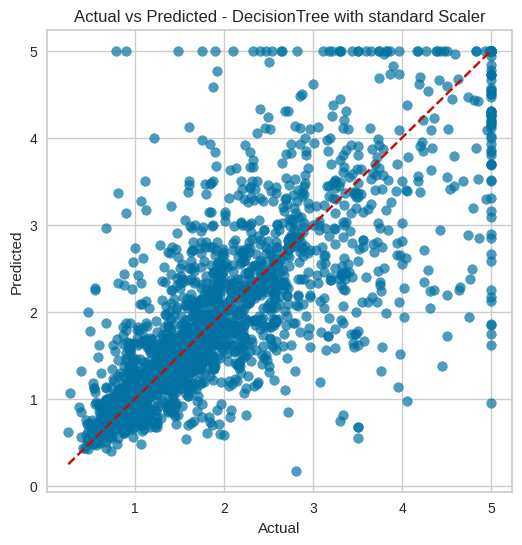

Elapsed time: 16.16 seconds


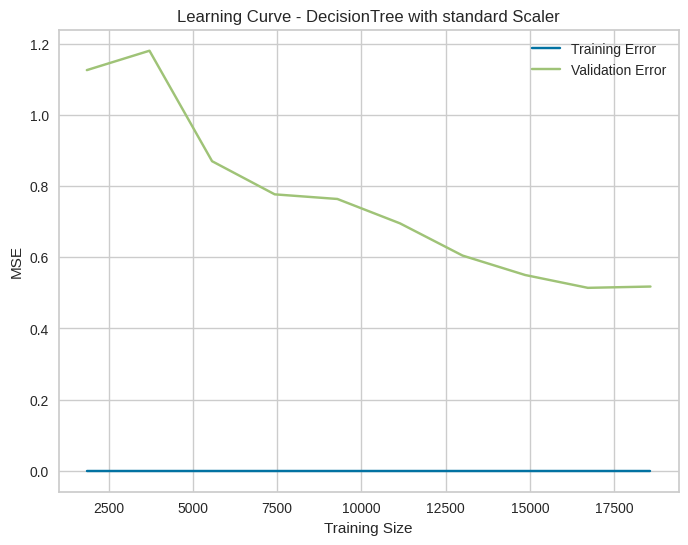

Scaler: robust, Model: DecisionTree, Average MSE: 0.5170


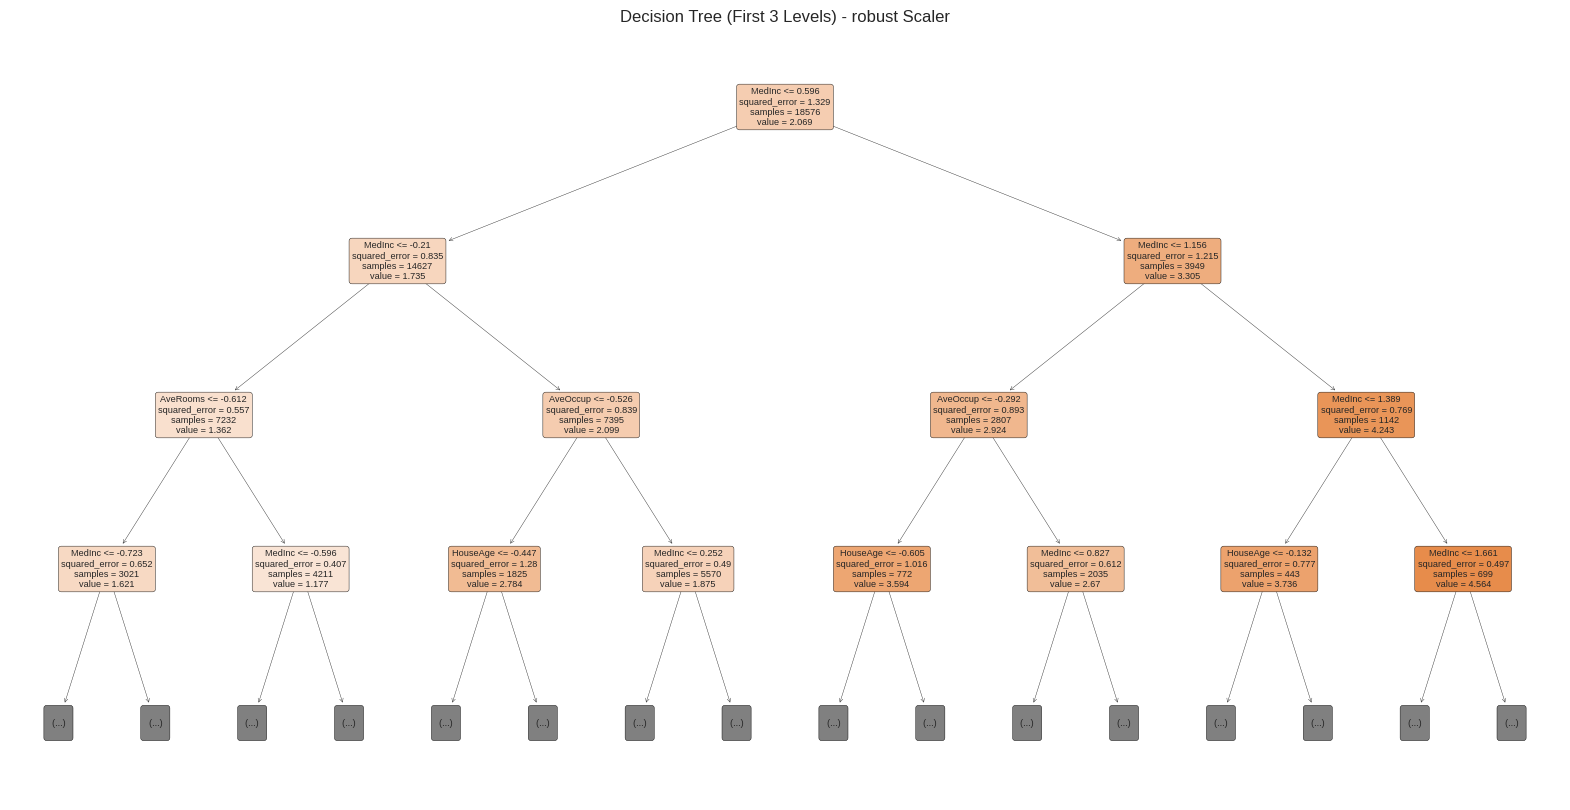

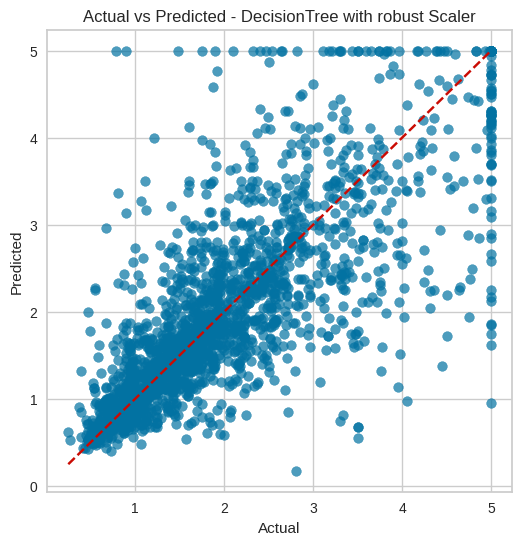

Elapsed time: 9.69 seconds


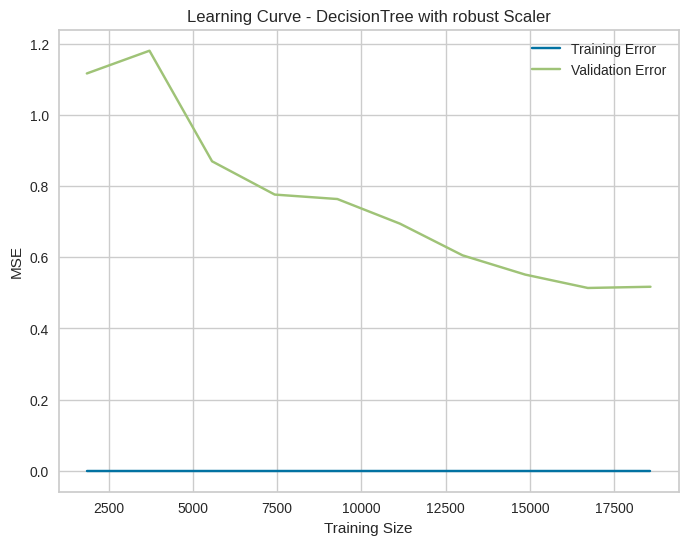

In [ ]:
# Parameters
num_features = X.shape[1] # Specify the number of features you want to include in the models (default X.shape[1])
scaling_options = {'standard': StandardScaler(), 'robust': RobustScaler()} # Options for scaling
models = {
    'DecisionTree': DecisionTreeRegressor(random_state=42)
} # Model options

# Select the top num_features for modeling
important_features = feature_importances['Feature'].head(num_features)
X_selected = X[important_features]

# Initialize cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Custom scorer for MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Loop through scaling options and models
for scale_name, scaler in scaling_options.items():
    for model_name, model in models.items():
        # Start the timer
        start_time = time.time()
        pipeline = Pipeline([
            ('scaler', scaler), # Is a scaler needed here???
            ('model', model)
        ])

        # Perform cross-validation
        mse_scores = cross_val_score(pipeline, X_selected, y, scoring=mse_scorer, cv=kf)

        # Report average MSE across folds
        avg_mse = -np.mean(mse_scores)  # Negate since sklearn returns negative MSE for scoring
        print(f"Scaler: {scale_name}, Model: {model_name}, Average MSE: {avg_mse:.4f}")

        # Visualizations for the final fold
        final_fold = list(kf.split(X_selected))[-1]  # Get the last train-test split
        train_index, test_index = final_fold
        X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)


      # Extract and plot the regression tree (first 3 levels only)
        decision_tree = pipeline.named_steps['model']
        plt.figure(figsize=(20, 10))
        plot_tree(decision_tree, feature_names=X_selected.columns, filled=True, rounded=True, max_depth=3)
        plt.title(f"Decision Tree (First 3 Levels) - {scale_name} Scaler")
        plt.show()

        # Plot actual vs predicted
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"Actual vs Predicted - {model_name} with {scale_name} Scaler")
        plt.show()

        # End the timer
        end_time = time.time()

        # Calculate the elapsed time
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.2f} seconds")

        # Generate learning curve
        train_sizes, train_scores, test_scores = learning_curve(
            pipeline, X_selected, y, cv=kf, scoring=mse_scorer, train_sizes=np.linspace(0.1, 1.0, 10))

        train_scores_mean = -np.mean(train_scores, axis=1)  # Convert to positive MSE
        test_scores_mean = -np.mean(test_scores, axis=1)  # Convert to positive MSE

        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores_mean, label="Training Error")
        plt.plot(train_sizes, test_scores_mean, label="Validation Error")
        plt.xlabel("Training Size")
        plt.ylabel("MSE")
        plt.title(f"Learning Curve - {model_name} with {scale_name} Scaler")
        plt.legend()
        plt.show()


##**Multiple Linear Regression**##

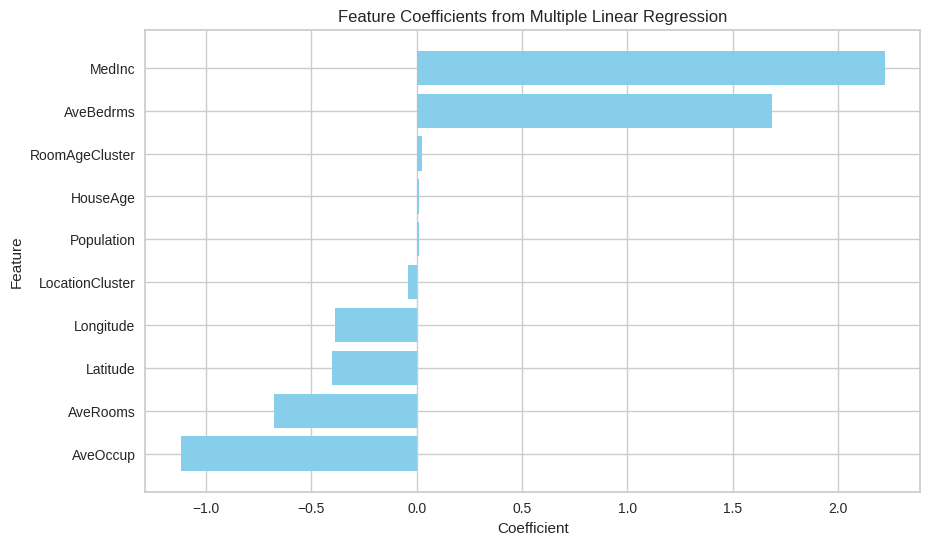

In [ ]:
# Determine feature importance for a multiple linear regression model
regressor = LinearRegression()
regressor.fit(X, y)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': regressor.coef_
}).sort_values(by='Coefficient', ascending=False)

# Plot feature coefficients
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'], color='skyblue')
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Coefficients from Multiple Linear Regression")
plt.gca().invert_yaxis()
plt.show()

Scaler: standard, Model: Lasso, Average MSE: 0.6356


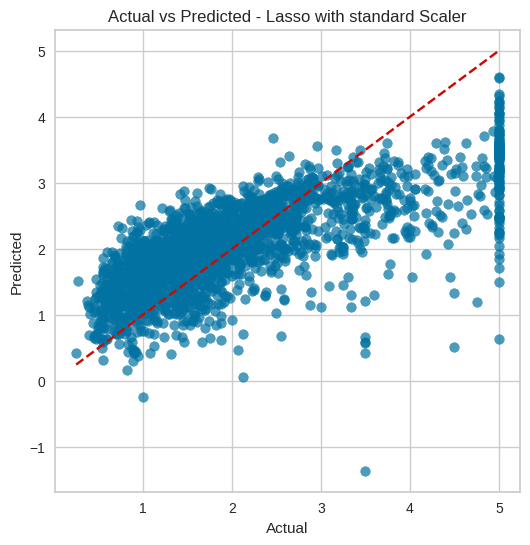

Elapsed time: 0.86 seconds


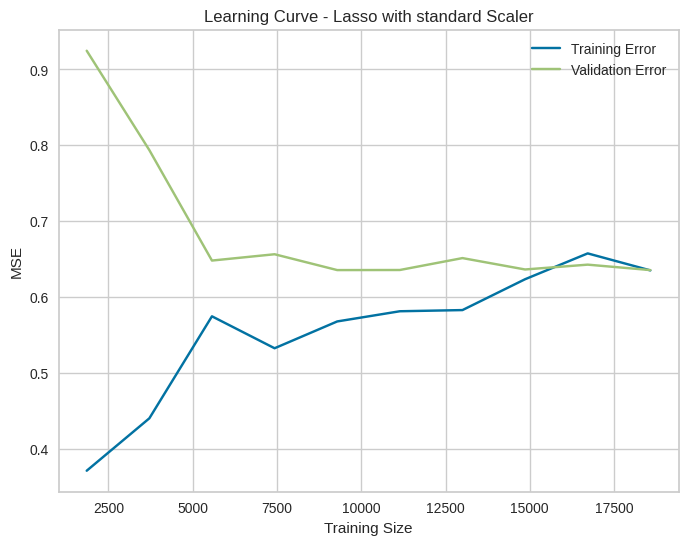

Scaler: standard, Model: Ridge, Average MSE: 0.4961


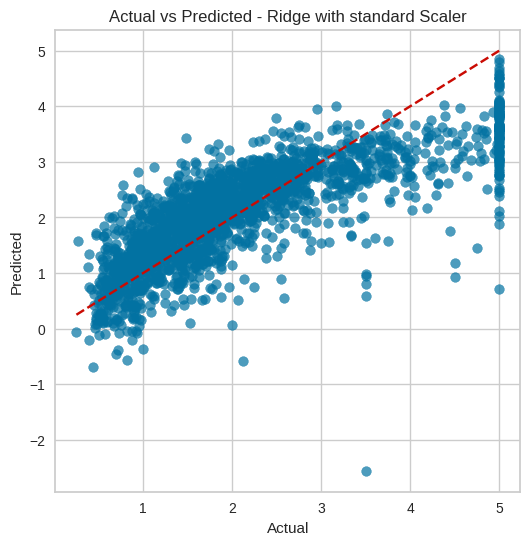

Elapsed time: 1.21 seconds


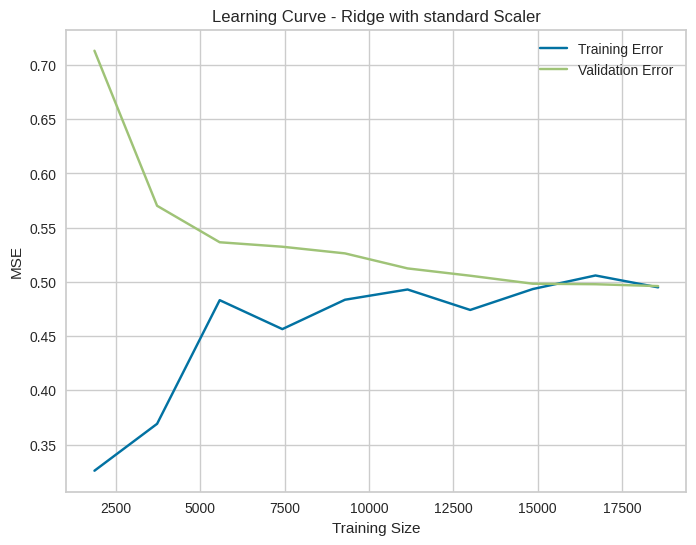

Scaler: standard, Model: ElasticNet, Average MSE: 0.5948


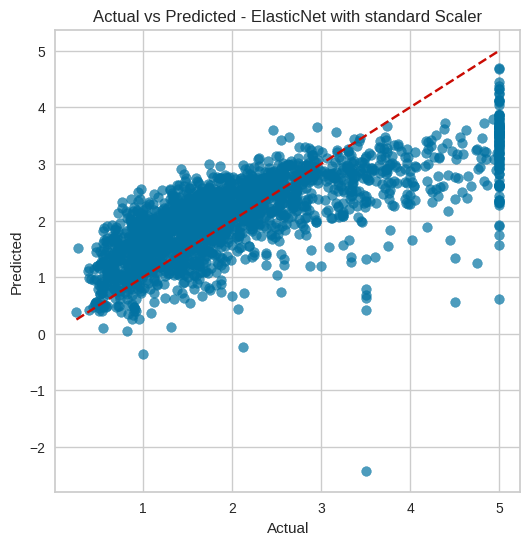

Elapsed time: 1.14 seconds


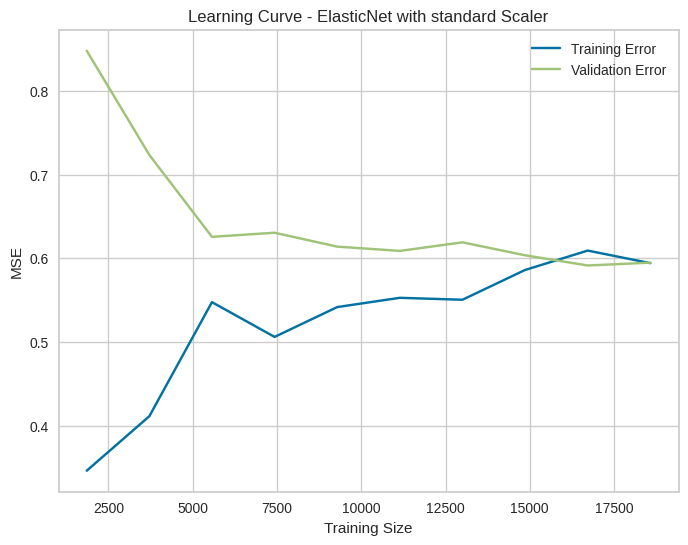

Scaler: standard, Model: LinearRegression, Average MSE: 0.4961


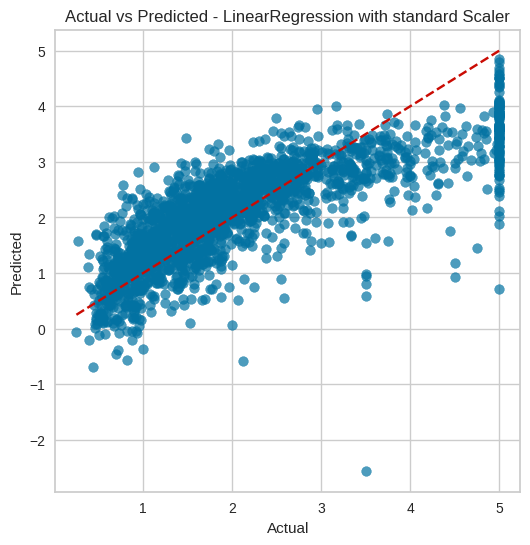

Elapsed time: 2.30 seconds


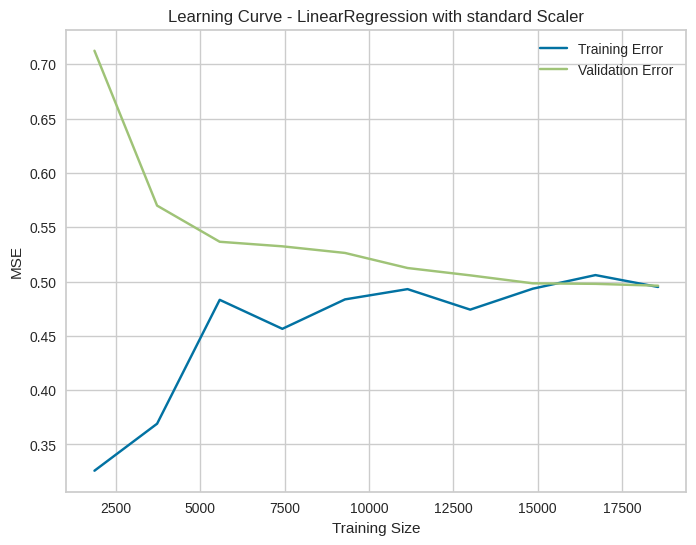

Scaler: robust, Model: Lasso, Average MSE: 0.6713


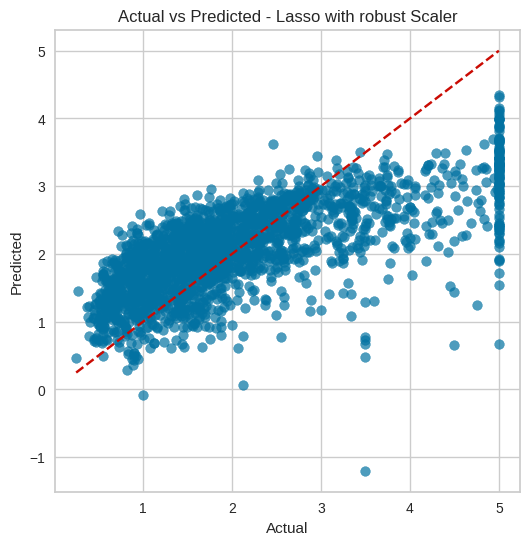

Elapsed time: 0.95 seconds


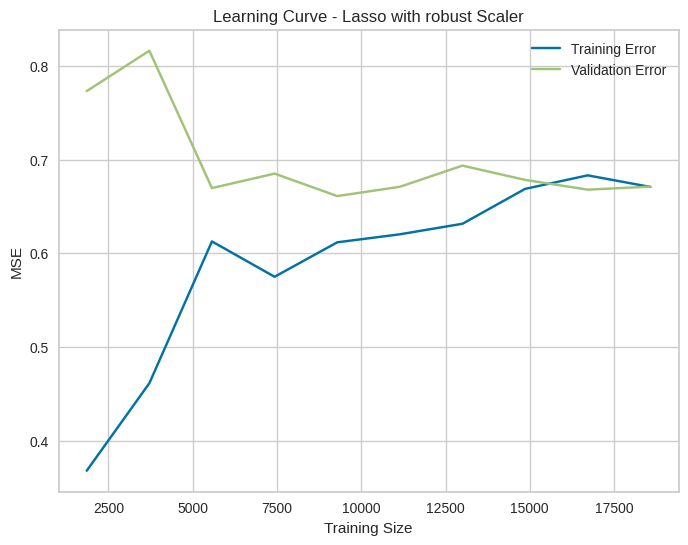

Scaler: robust, Model: Ridge, Average MSE: 0.4961


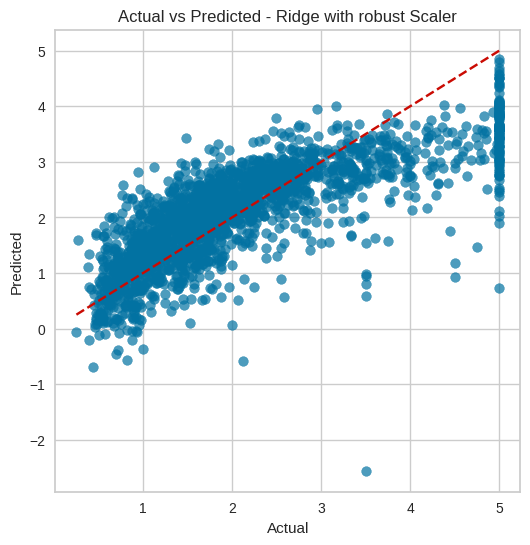

Elapsed time: 2.01 seconds


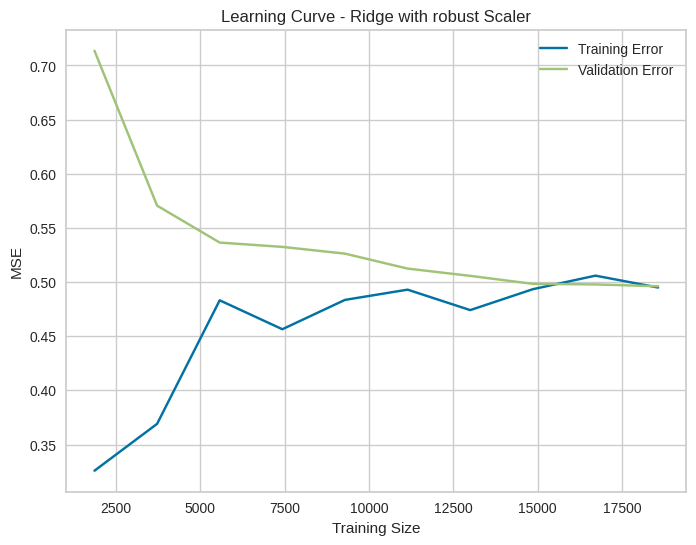

Scaler: robust, Model: ElasticNet, Average MSE: 0.6222


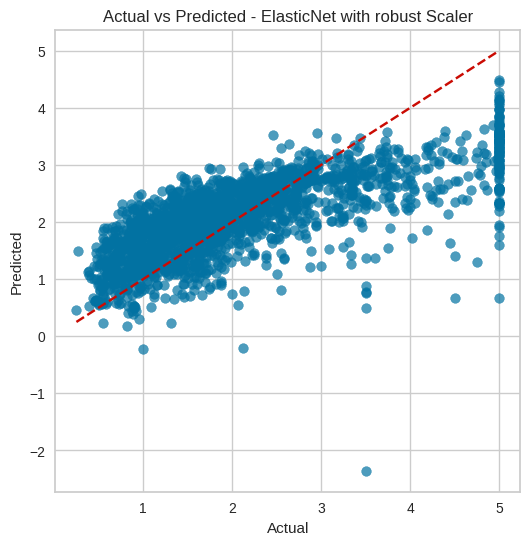

Elapsed time: 2.70 seconds


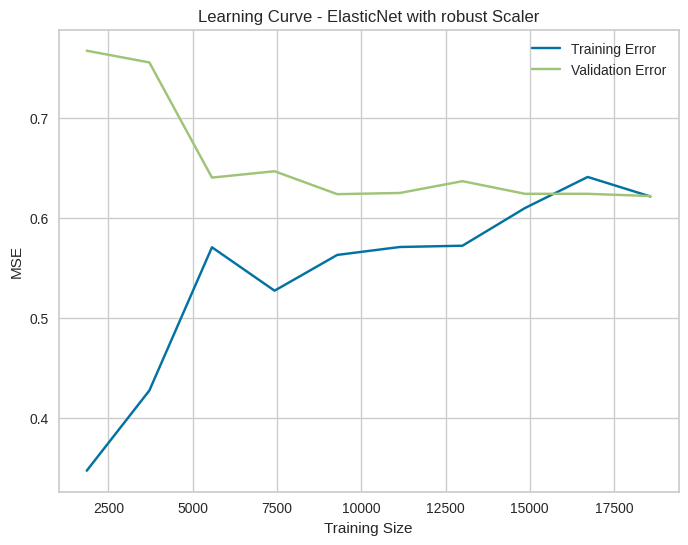

Scaler: robust, Model: LinearRegression, Average MSE: 0.4961


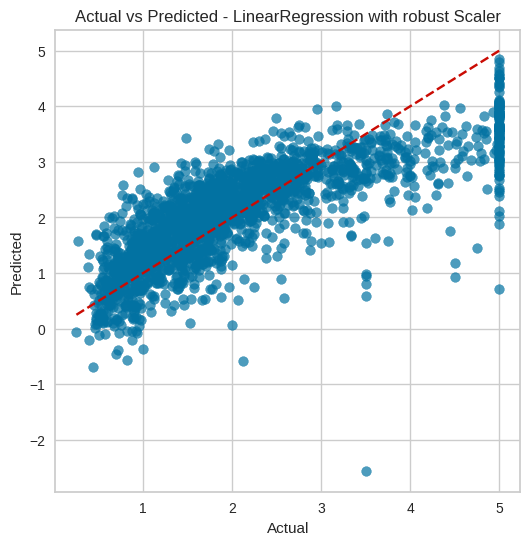

Elapsed time: 0.97 seconds


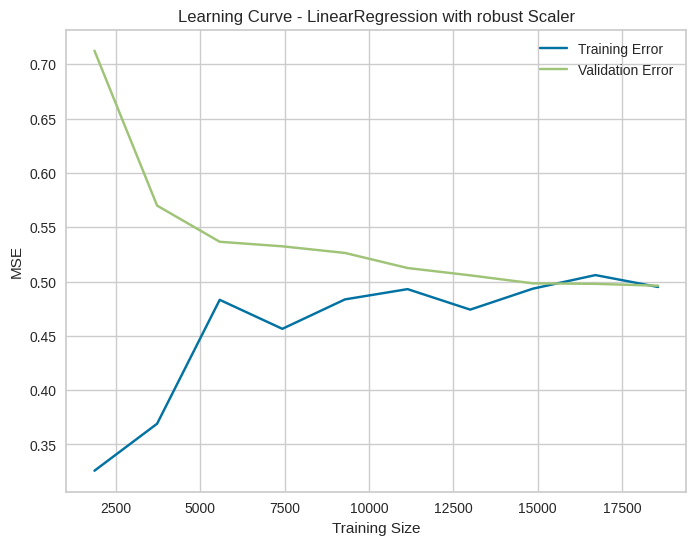

In [ ]:
# Parameters
num_features = min(10, X.shape[1])  # Specify the number of features to use for LinearRegression
scaling_options = {'standard': StandardScaler(), 'robust': RobustScaler()}  # Scaling options
models = {
    'Lasso': Lasso(alpha=0.1),
    'Ridge': Ridge(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'LinearRegression': LinearRegression()
}  # Model options

# Initialize cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Custom scorer for MSE
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Loop through scaling options and models
for scale_name, scaler in scaling_options.items():
    for model_name, model in models.items():
        # Start the timer
        start_time = time.time()
        # Create pipeline
        if model_name == 'LinearRegression':
            pipeline = Pipeline([
                ('scaler', scaler),
                ('feature_selection', SelectKBest(score_func=f_regression, k=num_features)),
                ('model', model)
            ])
        else:
            pipeline = Pipeline([
                ('scaler', scaler),
                ('model', model)
            ])

        # Perform cross-validation
        mse_scores = cross_val_score(pipeline, X, y, scoring=mse_scorer, cv=kf)

        # Report average MSE across folds
        avg_mse = -np.mean(mse_scores)  # Negate since sklearn returns negative MSE for scoring
        print(f"Scaler: {scale_name}, Model: {model_name}, Average MSE: {avg_mse:.4f}")

        # Visualizations for the final fold
        final_fold = list(kf.split(X))[-1]  # Get the last train-test split
        train_index, test_index = final_fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        # Plot actual vs predicted
        plt.figure(figsize=(6, 6))
        plt.scatter(y_test, y_pred, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel("Actual")
        plt.ylabel("Predicted")
        plt.title(f"Actual vs Predicted - {model_name} with {scale_name} Scaler")
        plt.show()

        # End the timer
        end_time = time.time()

        # Calculate the elapsed time
        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.2f} seconds")

        # Generate learning curve
        train_sizes, train_scores, test_scores = learning_curve(
            pipeline, X, y, cv=kf, scoring=mse_scorer, train_sizes=np.linspace(0.1, 1.0, 10))

        train_scores_mean = -np.mean(train_scores, axis=1)  # Convert to positive MSE
        test_scores_mean = -np.mean(test_scores, axis=1)  # Convert to positive MSE

        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, train_scores_mean, label="Training Error")
        plt.plot(train_sizes, test_scores_mean, label="Validation Error")
        plt.xlabel("Training Size")
        plt.ylabel("MSE")
        plt.title(f"Learning Curve - {model_name} with {scale_name} Scaler")
        plt.legend()
        plt.show()



##**PyTorch Lightning Regressor**##

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Selected Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'LocationCluster', 'RoomAgeCluster']


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Elapsed time: 773.80 seconds
Average MSE across 4 folds: 0.5094


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | model     | Sequential | 231    | train
1 | criterion | MSELoss    | 0      | train
-------------------------------------------------
231       Trainable params
0         Non-trainable params
231       Total params
0.001     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


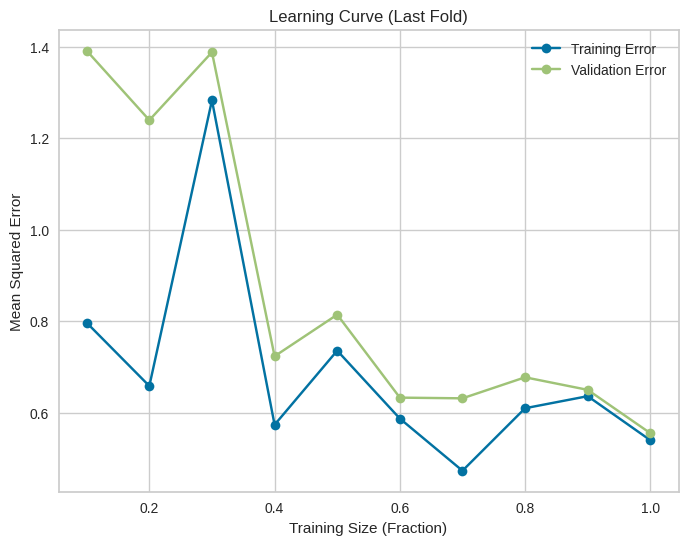

In [ ]:
#PyTorch Regressor

# Perform RFE to select top features
num_features = 10
rfe_selector = RFE(LinearRegression(), n_features_to_select=num_features)
X_selected = rfe_selector.fit_transform(X, y)
selected_feature_names = [feature_names[i] for i, support in enumerate(rfe_selector.support_) if support]
print(f"Selected Features: {selected_feature_names}")

# Define PyTorch Lightning Model
class HousingModel(pl.LightningModule):
    def __init__(self, input_dim):
        super(HousingModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )
        self.criterion = nn.MSELoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self(X).squeeze()
        loss = self.criterion(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Data Loader Function
def create_data_loader(X, y, batch_size=32):
    # Ensure y is a NumPy array
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    # Create TensorDataset
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Function for plotting the learning curve
def plot_learning_curve_last_fold(X_train, X_test, y_train, y_test, model_class, input_dim, batch_size=32, max_epochs=10, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_errors = []
    val_errors = []

    for train_size in train_sizes:
        # Use a subset of the training data
        train_subset_size = int(len(X_train) * train_size)
        X_train_subset = X_train[:train_subset_size]
        y_train_subset = y_train[:train_subset_size]

        # Create Data Loaders
        train_loader = create_data_loader(X_train_subset, y_train_subset, batch_size=batch_size)
        val_loader = create_data_loader(X_test, y_test, batch_size=batch_size)

        # Initialize model
        model = model_class(input_dim=input_dim)
        trainer = pl.Trainer(max_epochs=max_epochs, log_every_n_steps=1, enable_checkpointing=False)
        trainer.fit(model, train_loader)

        # Evaluate training error
        model.eval()
        train_preds, train_actuals = [], []
        for batch in train_loader:
            X_batch, y_batch = batch
            with torch.no_grad():
                y_hat = model(X_batch).detach().cpu().numpy().squeeze()
                if y_hat.ndim == 0:
                    y_hat = [y_hat]
                train_preds.extend(y_hat)
                train_actuals.extend(y_batch.numpy())
        train_mse = mean_squared_error(train_actuals, train_preds)
        train_errors.append(train_mse)

        # Evaluate validation error
        val_preds, val_actuals = [], []
        for batch in val_loader:
            X_batch, y_batch = batch
            with torch.no_grad():
                y_hat = model(X_batch).detach().cpu().numpy().squeeze()
                if y_hat.ndim == 0:
                    y_hat = [y_hat]
                val_preds.extend(y_hat)
                val_actuals.extend(y_batch.numpy())
        val_mse = mean_squared_error(val_actuals, val_preds)
        val_errors.append(val_mse)

    # Plot the learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_errors, label="Training Error", marker='o')
    plt.plot(train_sizes, val_errors, label="Validation Error", marker='o')
    plt.xlabel("Training Size (Fraction)")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve (Last Fold)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Cross-validation

# Start the timer
start_time = time.time()

kf = KFold(n_splits=4, shuffle=True, random_state=42)
mse_scores = []
final_fold = None

for i, (train_index, test_index) in enumerate(kf.split(X_selected)):
    X_train, X_test = X_selected[train_index], X_selected[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create Data Loaders
    train_loader = create_data_loader(X_train, y_train, batch_size=32)
    test_loader = create_data_loader(X_test, y_test, batch_size=32)

    # Initialize model
    model = HousingModel(input_dim=X_selected.shape[1])
    trainer = pl.Trainer(max_epochs=25, log_every_n_steps=1, enable_checkpointing=False)
    trainer.fit(model, train_loader)

    # Evaluate on test set
    model.eval()
    y_pred, y_true = [], []
    for batch in test_loader:
        X_batch, y_batch = batch
        with torch.no_grad():
            y_hat = model(X_batch).detach().cpu().numpy().squeeze()
            if y_hat.ndim == 0:
                y_hat = [y_hat]
            y_pred.extend(y_hat)
            y_true.extend(y_batch.numpy())
    mse = mean_squared_error(y_true, y_pred)
    mse_scores.append(mse)

    # Save the last fold for the learning curve
    if i == 3:
        final_fold = (X_train, X_test, y_train, y_test)

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

# Report MSE
print(f"Average MSE across 4 folds: {np.mean(mse_scores):.4f}")

# Plot Learning Curve for the Last Fold
X_train, X_test, y_train, y_test = final_fold
plot_learning_curve_last_fold(
    X_train=X_train,
    X_test=X_test,
    y_train=y_train,
    y_test=y_test,
    model_class=HousingModel,
    input_dim=X_selected.shape[1],
    batch_size=32,
    max_epochs=10
)

##**PyCaret Regressor**##

,Description,Value
0,Session id,42
1,Target,MedianHouseValue
2,Target type,Regression
3,Original data shape,"(20640, 11)"
4,Transformed data shape,"(20640, 11)"
5,Transformed train set shape,"(14447, 11)"
6,Transformed test set shape,"(6193, 11)"
7,Numeric features,10
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.3105,0.2317,0.4809,0.8267,0.1407,0.1631,1.3480
xgboost,Extreme Gradient Boosting,0.3109,0.2331,0.4824,0.8258,0.1412,0.1634,0.6590
et,Extra Trees Regressor,0.3205,0.2561,0.5056,0.8085,0.1451,0.1658,5.6890
rf,Random Forest Regressor,0.3293,0.2698,0.5189,0.7983,0.1503,0.1730,14.9600
gbr,Gradient Boosting Regressor,0.3638,0.2948,0.5425,0.7799,0.1590,0.1928,4.3090
knn,K Neighbors Regressor,0.4162,0.3819,0.6174,0.7148,0.1834,0.2227,0.3530
huber,Huber Regressor,0.4568,0.4385,0.6617,0.6726,0.1968,0.2470,0.2080
ridge,Ridge Regression,0.4632,0.4452,0.6667,0.6677,0.1973,0.2522,0.0980
lar,Least Angle Regression,0.4632,0.4451,0.6667,0.6677,0.1973,0.2522,0.0970
lr,Linear Regression,0.4632,0.4451,0.6667,0.6677,0.1973,0.2522,1.0420


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

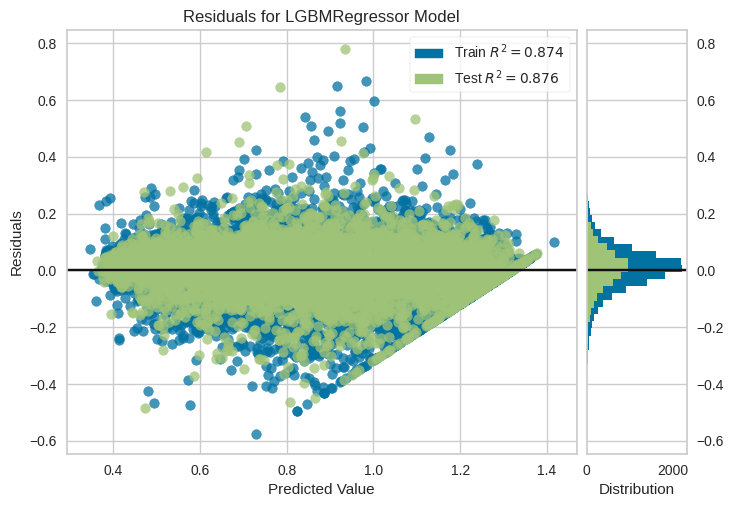

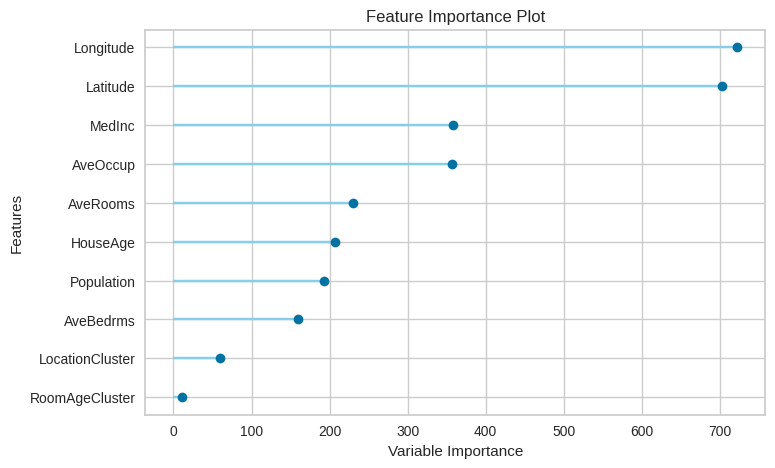

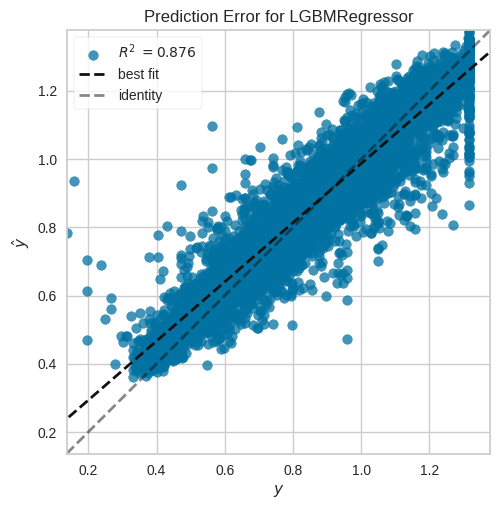

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.2851,0.1890,0.4347,0.8560,0.1260,0.1500


         MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  \
20046  0.986264      25.0  1.647158   0.704228    7.239215  1.584620   
3024   1.261666      30.0  1.798302   0.785495    7.356280  1.302857   
15663  1.499645      52.0  1.604858   0.782017    7.178545  0.858802   
20484  1.907704      17.0  1.969018   0.703198    7.441907  1.491655   
9814   1.552868      34.0  1.870723   0.707069    6.969790  1.248079   

        Latitude   Longitude  LocationCluster  RoomAgeCluster  \
20046  36.060001 -119.010002                2               3   
3024   35.139999 -119.459999                2               3   
15663  37.799999 -122.440002                0               2   
20484  34.279999 -118.720001                2               1   
9814   36.619999 -121.930000                0               0   

       MedianHouseValue  prediction_label  
20046           0.47700          0.537678  
3024            0.45800          0.841089  
15663           5.00001          4.384796  


In [ ]:
# PyCaret Regressor

data = pd.DataFrame(X, columns=[
    "MedInc", "HouseAge", "AveRooms", "AveBedrms", "Population", "AveOccup", "Latitude", "Longitude", "LocationCluster",	"RoomAgeCluster"
])
data['MedianHouseValue'] = y

# Start the timer
start_time = time.time()

# PyCaret regression setup
regression_setup = setup(
    data=data,
    target='MedianHouseValue',
    normalize=True,
    transform_target=True,
    session_id=42  # Seed for reproducibility
)

# Compare baseline models
best_model = compare_models()

# Finalize and evaluate the best model
final_model = finalize_model(best_model)
plot_model(final_model, plot='residuals')
plot_model(final_model, plot='feature')
plot_model(final_model, plot='error')

# Predict on new data
predictions = predict_model(final_model)
print(predictions.head())

# End the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

#**Conclusions**

The performance of the regressors tools for the full set of features is shown in the table below. These results depend upon the random number generators used to create the cross-validation folds (and associated models) and will vary each time you run the code. The "compute" column is an approximation of the time required to compute the cross-validated results.

|**Regressor** |       MSE      | Compute |
|:----------------------|:--------------:|:--------------:|
|Regression Tree (Standard Scaling) | 0.5176 | 2.98 sec |
|Regression Tree (Robust Scaling) | 0.5170 | 2.52 sec |
|Linear Regression (LASSO, Standard Scaling)   | 0.6356 | 0.46 sec |
|Linear Regression (Ridge, Standard Scaling)   | 0.4961 |  0.30 sec |
|Linear Regression (ElasticNet, Standard Scaling)   | 0.5948 |  0.46 sec |
|Linear Regression (Simple MLR, Standard Scaling)   | 0.4961 |  0.83 sec |
|Linear Regression (LASSO, Robust Scaling)   | 0.6713 |  0.62 sec |
|Linear Regression (Ridge, Robust Scaling)   | 0.4961 |  0.40 sec |
|Linear Regression (ElasticNet, Robust Scaling)   | 0.6222 |  0.58 sec |
|Linear Regression (Simple MLR, Robust Scaling)   | 0.4961 |  0.55 sec |
|PyTorch Lightning | 0.0.3460 |  539.76 sec |
|PyCaret (LightGBM) | 0.189 |  273.36 sec |


Overall, the PyCaret (LightGBM) model seems best. But the compute for that model is much higher and one of the linear regression models may deliver the best bang for your buck.

From the actual vs predicted graphs, it is clear that there are a number of similarly high-priced properties in the dataset that none of models are correctly valuing.